In [11]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt
from sklearn.metrics import classification_report,log_loss,confusion_matrix,balanced_accuracy_score

from joblib import dump, load

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [12]:
df = pd.read_csv('card_fraud_data.csv')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_hour,Time_min
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0


In [13]:
df.shape

(283726, 32)

In [14]:
X = df.iloc[:,df.columns!='Class']
y = df.iloc[:,df.columns=='Class']

In [15]:
#Using stratify = y so that ratio of class label is same in both training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25 , stratify=y, random_state=101)

In [16]:
X_train.shape,X_test.shape

((212794, 31), (70932, 31))

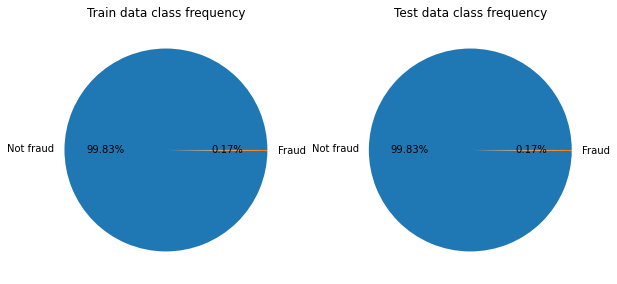

*************************************************
For training data
Class
0        99.833172
1         0.166828
dtype: float64
****************************
For testing data
Class
0        99.833643
1         0.166357
dtype: float64


In [17]:
freq = y_train.value_counts().sort_index().tolist()
label = ['Not fraud','Fraud']
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.pie(freq, labels = label,autopct='%1.2f%%')
plt.title('Train data class frequency')

plt.subplot(1, 2, 2)
plt.pie(freq, labels = label,autopct='%1.2f%%')
plt.title('Test data class frequency')
plt.show()

print('*************************************************')
print('For training data')
print(y_train.value_counts().sort_index()/y_train.shape[0]*100)
print('****************************')
print('For testing data')
print(y_test.value_counts().sort_index()/y_test.shape[0]*100)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
X_train.shape,X_test.shape

((212794, 31), (70932, 31))

Results for Logistic regression:-

Training time(sec) =  26.15646195411682
Prediction time(sec) =  0.4305551052093506


Training score =  0.8801522412166833
Tesing score =  0.8515960647444512


No of missclassified for class Not fraud (test data) = 14 
No of missclassified for class Fraud (test data) = 35 
Total no of missclassified points(test data) =  49
Total % of missclassified points(test data) =  0.0006908024586928325


Training log_loss =  0.0029134512144223233
Tesing log_loss =  0.004252431028875666


Confusion matrix:


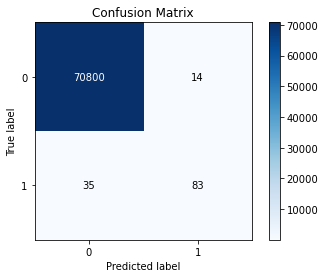



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.86      0.70      0.77       118

    accuracy                           1.00     70932
   macro avg       0.93      0.85      0.89     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [20]:
lr=LogisticRegression(class_weight='balanced',n_jobs=-1)
cv=RepeatedStratifiedKFold()
cal_lr = CalibratedClassifierCV(base_estimator=lr,cv=cv,method='isotonic',n_jobs=-1)

print('Results for Logistic regression:-\n')
start_time = time.time()
cal_lr.fit(X_train,y_train)
lr_time = (time.time() - start_time)
print('Training time(sec) = ',lr_time)


y_pred1 = cal_lr.predict(X_train)

start_time = time.time()
y_pred = cal_lr.predict(X_test)
lr_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',lr_time2)

y_pred_prob1 =cal_lr.predict_proba(X_train)
y_pred_prob=cal_lr.predict_proba(X_test)

cm_lr = confusion_matrix(y_test, y_pred)
lr_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_lr = balanced_accuracy_score(y_train,y_pred1)
acc2_lr = balanced_accuracy_score(y_test,y_pred)
loss1_lr = log_loss(y_train,y_pred_prob1)
loss2_lr = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_lr)
print('Tesing score = ',acc2_lr)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_lr[i])-cm_lr[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
    
print('Total no of missclassified points(test data) = ',lr_miss)
print('Total % of missclassified points(test data) = ',lr_miss/len(y_test))
print('\n\nTraining log_loss = ',loss1_lr)
print('Tesing log_loss = ',loss2_lr)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred) #normalize=True
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

LR = [acc1_lr,acc2_lr,lr_miss,lr_miss/len(y_test),loss1_lr,loss2_lr,lr_time,lr_time2]

Results for LDA machine:-

Training time(sec) =  20.926467895507812
Prediction time(sec) =  0.5337903499603271


Training score =  0.8984668076052188
Tesing score =  0.8643079291512308


No of missclassified for class Not fraud (test data) = 14 
No of missclassified for class Fraud (test data) = 32 
Total no of missclassified points(test data) =  46
Total % of missclassified points(test data) =  0.0006485084306095979


Training log_loss =  0.002782585151489804
Tesing log_loss =  0.0035777825944916845


Confusion matrix:


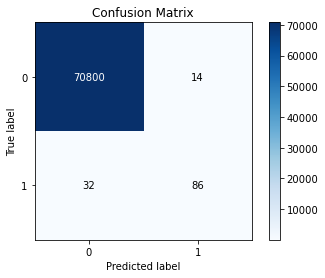



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.86      0.73      0.79       118

    accuracy                           1.00     70932
   macro avg       0.93      0.86      0.89     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(priors=[0.5,0.5])
cv=RepeatedStratifiedKFold()
cal_lda = CalibratedClassifierCV(base_estimator=lda,cv=cv,method='isotonic',n_jobs=-1)

print('Results for LDA machine:-\n')

start_time = time.time()
cal_lda.fit(X_train,y_train)
lda_time = (time.time() - start_time)
print('Training time(sec) = ',lda_time)

y_pred1 = cal_lda.predict(X_train)
start_time = time.time()
y_pred = cal_lda.predict(X_test)
lda_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',lda_time2)

y_pred_prob1 = cal_lda.predict_proba(X_train)
y_pred_prob = cal_lda.predict_proba(X_test)

cm_lda = confusion_matrix(y_test, y_pred)
lda_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_lda = balanced_accuracy_score(y_train,y_pred1)
acc2_lda = balanced_accuracy_score(y_test,y_pred)
loss1_lda = log_loss(y_train,y_pred_prob1)
loss2_lda = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_lda)
print('Tesing score = ',acc2_lda)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_lda[i])-cm_lda[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',lda_miss)
print('Total % of missclassified points(test data) = ',lda_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_lda)
print('Tesing log_loss = ',loss2_lda)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

LDA = [acc1_lda,acc2_lda,lda_miss,lda_miss/len(y_test),loss1_lda,loss2_lda,lda_time,lda_time2]

Results for QDA machine:-

Training time(sec) =  18.511280059814453
Prediction time(sec) =  5.013073444366455


Training score =  0.760408041572696
Tesing score =  0.7328884501915498


No of missclassified for class Not fraud (test data) = 23 
No of missclassified for class Fraud (test data) = 63 
Total no of missclassified points(test data) =  86
Total % of missclassified points(test data) =  0.0012124288050527265


Training log_loss =  0.0039619715015315644
Tesing log_loss =  0.004717099685996861


Confusion matrix:


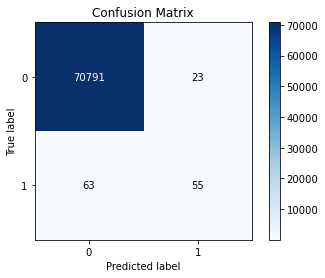



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.71      0.47      0.56       118

    accuracy                           1.00     70932
   macro avg       0.85      0.73      0.78     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [22]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(priors=[0.5,0.5])
cv=RepeatedStratifiedKFold()
cal_qda = CalibratedClassifierCV(base_estimator=qda,cv=cv,method='isotonic',n_jobs=-1)

print('Results for QDA machine:-\n')

start_time = time.time()
cal_qda.fit(X_train,y_train)
qda_time = (time.time() - start_time)
print('Training time(sec) = ',qda_time)

y_pred1 = cal_qda.predict(X_train)
start_time = time.time()
y_pred = cal_qda.predict(X_test)
qda_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',qda_time2)

y_pred_prob1 = cal_qda.predict_proba(X_train)
y_pred_prob = cal_qda.predict_proba(X_test)

cm_qda = confusion_matrix(y_test, y_pred)
qda_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_qda = balanced_accuracy_score(y_train,y_pred1)
acc2_qda = balanced_accuracy_score(y_test,y_pred)
loss1_qda = log_loss(y_train,y_pred_prob1)
loss2_qda = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_qda)
print('Tesing score = ',acc2_qda)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_qda[i])-cm_qda[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',qda_miss)
print('Total % of missclassified points(test data) = ',qda_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_qda)
print('Tesing log_loss = ',loss2_qda)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

QDA = [acc1_qda,acc2_qda,qda_miss,qda_miss/len(y_test),loss1_qda,loss2_qda,qda_time,qda_time2]

Results for Gaussian naive bayes:-

Training time(sec) =  0.20006322860717773
Prediction time(sec) =  0.0468897819519043


Training score =  0.9195577401539424
Tesing score =  0.8981875651324334


No of missclassified for class Not fraud (test data) = 1817 
No of missclassified for class Fraud (test data) = 21 
Total no of missclassified points(test data) =  1838
Total % of missclassified points(test data) =  0.02591214120566176


Training log_loss =  0.609469886817118
Tesing log_loss =  0.6064183222397505


Confusion matrix:


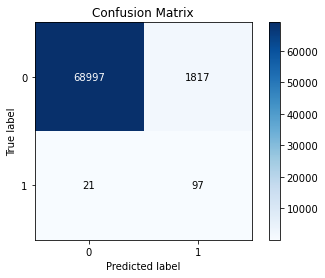



Classification report:-

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     70814
           1       0.05      0.82      0.10       118

    accuracy                           0.97     70932
   macro avg       0.53      0.90      0.54     70932
weighted avg       1.00      0.97      0.99     70932

**************************************************************************


In [23]:
from sklearn.naive_bayes import GaussianNB
cal_mnb = GaussianNB(priors=[0.5,0.5])
# cv=RepeatedStratifiedKFold()
# cal_mnb = CalibratedClassifierCV(base_estimator=mnb,cv=cv,method='isotonic',n_jobs=-1)

print('Results for Gaussian naive bayes:-\n')
start_time = time.time()
cal_mnb.fit(X_train,y_train)
mnb_time = (time.time() - start_time)
print('Training time(sec) = ',mnb_time)

y_pred1 = cal_mnb.predict(X_train)

start_time = time.time()
y_pred = cal_mnb.predict(X_test)
mnb_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',mnb_time2)

y_pred_prob1 = cal_mnb.predict_proba(X_train)
y_pred_prob = cal_mnb.predict_proba(X_test)

cm_mnb = confusion_matrix(y_test, y_pred)
mnb_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_mnb = balanced_accuracy_score(y_train,y_pred1)
acc2_mnb = balanced_accuracy_score(y_test,y_pred)
loss1_mnb = log_loss(y_train,y_pred_prob1)
loss2_mnb = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_mnb)
print('Tesing score = ',acc2_mnb)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_mnb[i])-cm_mnb[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',mnb_miss)
print('Total % of missclassified points(test data) = ',mnb_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_mnb)
print('Tesing log_loss = ',loss2_mnb)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

MNB = [acc1_mnb,acc2_mnb,mnb_miss,mnb_miss/len(y_test),loss1_mnb,loss2_mnb,mnb_time,mnb_time2]

Results for Linear support vector machine:-

Training time(sec) =  832.0463778972626
Prediction time(sec) =  0.4576685428619385


Training score =  0.885816641052023
Tesing score =  0.847365837359557


No of missclassified for class Not fraud (test data) = 13 
No of missclassified for class Fraud (test data) = 36 
Total no of missclassified points(test data) =  49
Total % of missclassified points(test data) =  0.0006908024586928325


Training log_loss =  0.002794640193923968
Tesing log_loss =  0.0037525367382316445


Confusion matrix:


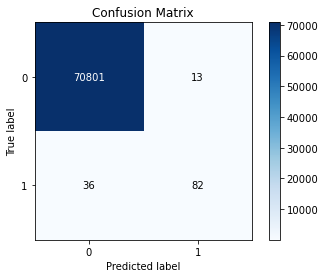



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.86      0.69      0.77       118

    accuracy                           1.00     70932
   macro avg       0.93      0.85      0.88     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [24]:
from sklearn.svm import LinearSVC

svc = LinearSVC(class_weight='balanced')
cv=RepeatedStratifiedKFold()
cal_svc = CalibratedClassifierCV(base_estimator=svc,cv=cv,method='isotonic',n_jobs=-1)

print('Results for Linear support vector machine:-\n')

start_time = time.time()
cal_svc.fit(X_train,y_train)
svc_time = (time.time() - start_time)
print('Training time(sec) = ',svc_time)

y_pred1 = cal_svc.predict(X_train)
start_time = time.time()
y_pred = cal_svc.predict(X_test)
svc_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',svc_time2)

y_pred_prob1 = cal_svc.predict_proba(X_train)
y_pred_prob = cal_svc.predict_proba(X_test)

cm_svc = confusion_matrix(y_test, y_pred)
svc_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_svc = balanced_accuracy_score(y_train,y_pred1)
acc2_svc = balanced_accuracy_score(y_test,y_pred)
loss1_svc = log_loss(y_train,y_pred_prob1)
loss2_svc = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_svc)
print('Tesing score = ',acc2_svc)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_svc[i])-cm_svc[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',svc_miss)
print('Total % of missclassified points(test data) = ',svc_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_svc)
print('Tesing log_loss = ',loss2_svc)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

SVC = [acc1_svc,acc2_svc,svc_miss,svc_miss/len(y_test),loss1_svc,loss2_svc,svc_time,svc_time2]

Results for Decision Tree classifier:-

Training time(sec) =  110.03084468841553
Prediction time(sec) =  0.8313157558441162


Training score =  1.0
Tesing score =  0.8516596115007422


No of missclassified for class Not fraud (test data) = 5 
No of missclassified for class Fraud (test data) = 35 
Total no of missclassified points(test data) =  40
Total % of missclassified points(test data) =  0.0005639203744431286


Training log_loss =  0.0010755956445084966
Tesing log_loss =  0.003991797299921194


Confusion matrix:


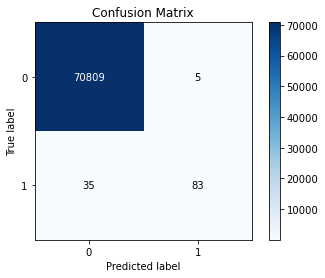



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.94      0.70      0.81       118

    accuracy                           1.00     70932
   macro avg       0.97      0.85      0.90     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [25]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced')
cv=RepeatedStratifiedKFold()
cal_dt = CalibratedClassifierCV(base_estimator=dt,cv=cv,method='isotonic',n_jobs=-1)

print('Results for Decision Tree classifier:-\n')

start_time = time.time()
cal_dt.fit(X_train,y_train)
dt_time = (time.time() - start_time)
print('Training time(sec) = ',dt_time)

y_pred1 = cal_dt.predict(X_train)

start_time = time.time()
y_pred = cal_dt.predict(X_test)
dt_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',dt_time2)

y_pred_prob1 = cal_dt.predict_proba(X_train)
y_pred_prob = cal_dt.predict_proba(X_test)

cm_dt = confusion_matrix(y_test, y_pred)
dt_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_dt = balanced_accuracy_score(y_train,y_pred1)
acc2_dt = balanced_accuracy_score(y_test,y_pred)
loss1_dt = log_loss(y_train,y_pred_prob1)
loss2_dt = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_dt)
print('Tesing score = ',acc2_dt)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_dt[i])-cm_dt[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',dt_miss)
print('Total % of missclassified points(test data) = ',dt_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_dt)
print('Tesing log_loss = ',loss2_dt)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')
DT = [acc1_dt,acc2_dt,dt_miss,dt_miss/len(y_test),loss1_dt,loss2_dt,dt_time,dt_time2]

In [26]:
s1=[MNB,LR,LDA,QDA,SVC,DT]
s2=['GNB','LR','LDA','QDA','SVC','DT']
col=['Train score','Test score','Missclassified-point','% missclasification','Train log-loss','Test log-loss','Training time','Prediction time']
result=dict.fromkeys(s2,None)

for i in range(len(s1)):
    result[s2[i]] = s1[i]

In [27]:
temp = pd.DataFrame.from_dict(result, orient='index',columns=col).reset_index()
result = temp.rename(columns={'index':'Classifiers'})

In [28]:
result

,Classifiers,Train score,Test score,Missclassified-point,% missclasification,Train log-loss,Test log-loss,Training time,Prediction time
0,GNB,0.919558,0.898188,1838,0.025912,0.609470,0.606418,0.200063,0.046890
1,LR,0.880152,0.851596,49,0.000691,0.002913,0.004252,26.156462,0.430555
2,LDA,0.898467,0.864308,46,0.000649,0.002783,0.003578,20.926468,0.533790
3,QDA,0.760408,0.732888,86,0.001212,0.003962,0.004717,18.511280,5.013073
4,SVC,0.885817,0.847366,49,0.000691,0.002795,0.003753,832.046378,0.457669
5,DT,1.000000,0.851660,40,0.000564,0.001076,0.003992,110.030845,0.831316


<h5>Since many features are not useful we can reduce the dimensions using pca which will remove correlated features</h5>

In [29]:
X = df.iloc[:,df.columns!='Class']
y = df.iloc[:,df.columns=='Class']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25 , stratify=y, random_state=101)

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X_train.shape[1])
X_tr = pca.fit_transform(X_train)
X_te = pca.transform(X_test)

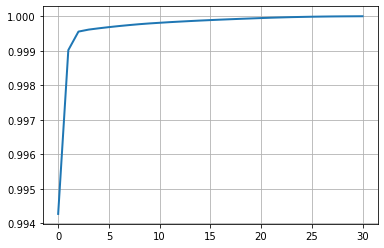

In [31]:
per=pca.explained_variance_/np.sum(pca.explained_variance_)
s=np.cumsum(per)

import matplotlib.pyplot as plt
plt.figure(1,figsize=(6,4))
plt.clf()
plt.plot(s,linewidth=2)
plt.grid()
plt.show()

In [32]:
s

array([0.99427607, 0.99901907, 0.99955532, 0.99961305, 0.99965076,
       0.99968499, 0.99971601, 0.99974413, 0.99976995, 0.99979198,
       0.9998105 , 0.99982896, 0.99984516, 0.99986065, 0.99987517,
       0.99988852, 0.99990178, 0.99991375, 0.99992547, 0.99993641,
       0.99994728, 0.99995757, 0.99996605, 0.9999743 , 0.99998049,
       0.99998623, 0.99999052, 0.99999415, 0.99999667, 0.99999839,
       1.        ])

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=21)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
X_train.shape,X_test.shape

((212794, 21), (70932, 21))

Results for Logistic regression:-

Training time(sec) =  10.799075603485107
Prediction time(sec) =  0.40738725662231445


Training score =  0.8731052804619507
Tesing score =  0.847365837359557


No of missclassified for class Not fraud (test data) = 13 
No of missclassified for class Fraud (test data) = 36 
Total no of missclassified points(test data) =  49
Total % of missclassified points(test data) =  0.0006908024586928325


Training log_loss =  0.0029598665256450785
Tesing log_loss =  0.00392552903740859


Confusion matrix:


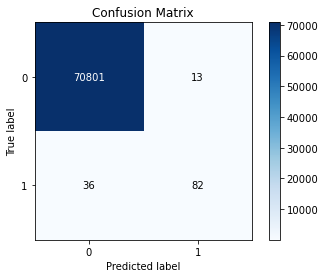



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.86      0.69      0.77       118

    accuracy                           1.00     70932
   macro avg       0.93      0.85      0.88     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [36]:
lr=LogisticRegression(class_weight='balanced',n_jobs=-1)
cv=RepeatedStratifiedKFold()
cal_lr = CalibratedClassifierCV(base_estimator=lr,cv=cv,method='isotonic',n_jobs=-1)

print('Results for Logistic regression:-\n')
start_time = time.time()
cal_lr.fit(X_train,y_train)
lr_time = (time.time() - start_time)
print('Training time(sec) = ',lr_time)


y_pred1 = cal_lr.predict(X_train)

start_time = time.time()
y_pred = cal_lr.predict(X_test)
lr_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',lr_time2)

y_pred_prob1 =cal_lr.predict_proba(X_train)
y_pred_prob=cal_lr.predict_proba(X_test)

cm_lr = confusion_matrix(y_test, y_pred)
lr_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_lr = balanced_accuracy_score(y_train,y_pred1)
acc2_lr = balanced_accuracy_score(y_test,y_pred)
loss1_lr = log_loss(y_train,y_pred_prob1)
loss2_lr = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_lr)
print('Tesing score = ',acc2_lr)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_lr[i])-cm_lr[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
    
print('Total no of missclassified points(test data) = ',lr_miss)
print('Total % of missclassified points(test data) = ',lr_miss/len(y_test))
print('\n\nTraining log_loss = ',loss1_lr)
print('Tesing log_loss = ',loss2_lr)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred) #normalize=True
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

LR = [acc1_lr,acc2_lr,lr_miss,lr_miss/len(y_test),loss1_lr,loss2_lr,lr_time,lr_time2]

Results for LDA machine:-

Training time(sec) =  12.517992973327637
Prediction time(sec) =  0.40514135360717773


Training score =  0.8942438091093456
Tesing score =  0.8643149899019298


No of missclassified for class Not fraud (test data) = 13 
No of missclassified for class Fraud (test data) = 32 
Total no of missclassified points(test data) =  45
Total % of missclassified points(test data) =  0.0006344104212485198


Training log_loss =  0.002915261994799498
Tesing log_loss =  0.0036879667121942866


Confusion matrix:


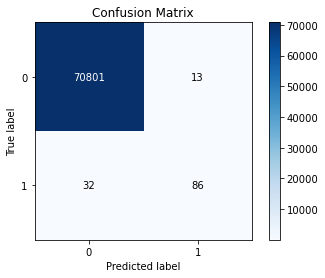



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.87      0.73      0.79       118

    accuracy                           1.00     70932
   macro avg       0.93      0.86      0.90     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(priors=[0.5,0.5])
cv=RepeatedStratifiedKFold()
cal_lda = CalibratedClassifierCV(base_estimator=lda,cv=cv,method='isotonic',n_jobs=-1)

print('Results for LDA machine:-\n')

start_time = time.time()
cal_lda.fit(X_train,y_train)
lda_time = (time.time() - start_time)
print('Training time(sec) = ',lda_time)

y_pred1 = cal_lda.predict(X_train)
start_time = time.time()
y_pred = cal_lda.predict(X_test)
lda_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',lda_time2)

y_pred_prob1 = cal_lda.predict_proba(X_train)
y_pred_prob = cal_lda.predict_proba(X_test)

cm_lda = confusion_matrix(y_test, y_pred)
lda_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_lda = balanced_accuracy_score(y_train,y_pred1)
acc2_lda = balanced_accuracy_score(y_test,y_pred)
loss1_lda = log_loss(y_train,y_pred_prob1)
loss2_lda = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_lda)
print('Tesing score = ',acc2_lda)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_lda[i])-cm_lda[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',lda_miss)
print('Total % of missclassified points(test data) = ',lda_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_lda)
print('Tesing log_loss = ',loss2_lda)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

LDA = [acc1_lda,acc2_lda,lda_miss,lda_miss/len(y_test),loss1_lda,loss2_lda,lda_time,lda_time2]

Results for QDA machine:-

Training time(sec) =  10.979390144348145
Prediction time(sec) =  3.282240152359009


Training score =  0.8448962548917935
Tesing score =  0.8261017284239016


No of missclassified for class Not fraud (test data) = 24 
No of missclassified for class Fraud (test data) = 41 
Total no of missclassified points(test data) =  65
Total % of missclassified points(test data) =  0.000916370608470084


Training log_loss =  0.0036039252961287383
Tesing log_loss =  0.0044072095018698205


Confusion matrix:


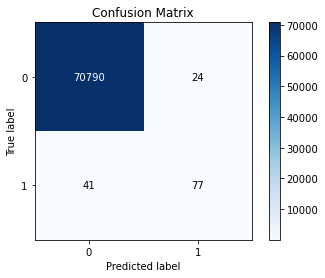



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.76      0.65      0.70       118

    accuracy                           1.00     70932
   macro avg       0.88      0.83      0.85     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [38]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(priors=[0.5,0.5])
cv=RepeatedStratifiedKFold()
cal_qda = CalibratedClassifierCV(base_estimator=qda,cv=cv,method='isotonic',n_jobs=-1)

print('Results for QDA machine:-\n')

start_time = time.time()
cal_qda.fit(X_train,y_train)
qda_time = (time.time() - start_time)
print('Training time(sec) = ',qda_time)

y_pred1 = cal_qda.predict(X_train)
start_time = time.time()
y_pred = cal_qda.predict(X_test)
qda_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',qda_time2)

y_pred_prob1 = cal_qda.predict_proba(X_train)
y_pred_prob = cal_qda.predict_proba(X_test)

cm_qda = confusion_matrix(y_test, y_pred)
qda_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_qda = balanced_accuracy_score(y_train,y_pred1)
acc2_qda = balanced_accuracy_score(y_test,y_pred)
loss1_qda = log_loss(y_train,y_pred_prob1)
loss2_qda = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_qda)
print('Tesing score = ',acc2_qda)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_qda[i])-cm_qda[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',qda_miss)
print('Total % of missclassified points(test data) = ',qda_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_qda)
print('Tesing log_loss = ',loss2_qda)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

QDA = [acc1_qda,acc2_qda,qda_miss,qda_miss/len(y_test),loss1_qda,loss2_qda,qda_time,qda_time2]

Results for Gaussian naive bayes:-

Training time(sec) =  0.1146852970123291
Prediction time(sec) =  0.03311800956726074


Training score =  0.9201865337449975
Tesing score =  0.9015908469693583


No of missclassified for class Not fraud (test data) = 1335 
No of missclassified for class Fraud (test data) = 21 
Total no of missclassified points(test data) =  1356
Total % of missclassified points(test data) =  0.019116900693622062


Training log_loss =  0.4153017387719353
Tesing log_loss =  0.4039147704431233


Confusion matrix:


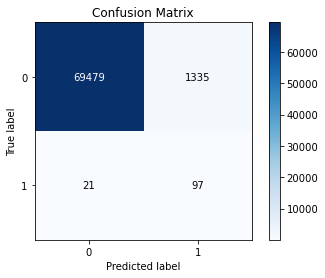



Classification report:-

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70814
           1       0.07      0.82      0.13       118

    accuracy                           0.98     70932
   macro avg       0.53      0.90      0.56     70932
weighted avg       1.00      0.98      0.99     70932

**************************************************************************


In [39]:
from sklearn.naive_bayes import GaussianNB
cal_mnb = GaussianNB(priors=[0.5,0.5])
# cv=RepeatedStratifiedKFold()
# cal_mnb = CalibratedClassifierCV(base_estimator=mnb,cv=cv,method='isotonic',n_jobs=-1)

print('Results for Gaussian naive bayes:-\n')
start_time = time.time()
cal_mnb.fit(X_train,y_train)
mnb_time = (time.time() - start_time)
print('Training time(sec) = ',mnb_time)

y_pred1 = cal_mnb.predict(X_train)

start_time = time.time()
y_pred = cal_mnb.predict(X_test)
mnb_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',mnb_time2)

y_pred_prob1 = cal_mnb.predict_proba(X_train)
y_pred_prob = cal_mnb.predict_proba(X_test)

cm_mnb = confusion_matrix(y_test, y_pred)
mnb_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_mnb = balanced_accuracy_score(y_train,y_pred1)
acc2_mnb = balanced_accuracy_score(y_test,y_pred)
loss1_mnb = log_loss(y_train,y_pred_prob1)
loss2_mnb = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_mnb)
print('Tesing score = ',acc2_mnb)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_mnb[i])-cm_mnb[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',mnb_miss)
print('Total % of missclassified points(test data) = ',mnb_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_mnb)
print('Tesing log_loss = ',loss2_mnb)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

MNB = [acc1_mnb,acc2_mnb,mnb_miss,mnb_miss/len(y_test),loss1_mnb,loss2_mnb,mnb_time,mnb_time2]

Results for Linear support vector machine:-

Training time(sec) =  665.7490940093994
Prediction time(sec) =  0.3921034336090088


Training score =  0.8844152511982064
Tesing score =  0.8431426707253616


No of missclassified for class Not fraud (test data) = 11 
No of missclassified for class Fraud (test data) = 37 
Total no of missclassified points(test data) =  48
Total % of missclassified points(test data) =  0.0006767044493317544


Training log_loss =  0.0027879950217018575
Tesing log_loss =  0.0037193914812423475


Confusion matrix:


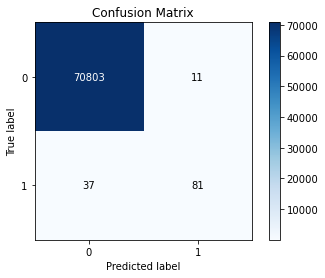



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.88      0.69      0.77       118

    accuracy                           1.00     70932
   macro avg       0.94      0.84      0.89     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [40]:
from sklearn.svm import LinearSVC

svc = LinearSVC(class_weight='balanced')
cv=RepeatedStratifiedKFold()
cal_svc = CalibratedClassifierCV(base_estimator=svc,cv=cv,method='isotonic',n_jobs=-1)

print('Results for Linear support vector machine:-\n')

start_time = time.time()
cal_svc.fit(X_train,y_train)
svc_time = (time.time() - start_time)
print('Training time(sec) = ',svc_time)

y_pred1 = cal_svc.predict(X_train)
start_time = time.time()
y_pred = cal_svc.predict(X_test)
svc_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',svc_time2)

y_pred_prob1 = cal_svc.predict_proba(X_train)
y_pred_prob = cal_svc.predict_proba(X_test)

cm_svc = confusion_matrix(y_test, y_pred)
svc_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_svc = balanced_accuracy_score(y_train,y_pred1)
acc2_svc = balanced_accuracy_score(y_test,y_pred)
loss1_svc = log_loss(y_train,y_pred_prob1)
loss2_svc = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_svc)
print('Tesing score = ',acc2_svc)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_svc[i])-cm_svc[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',svc_miss)
print('Total % of missclassified points(test data) = ',svc_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_svc)
print('Tesing log_loss = ',loss2_svc)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')

SVC = [acc1_svc,acc2_svc,svc_miss,svc_miss/len(y_test),loss1_svc,loss2_svc,svc_time,svc_time2]

Results for Decision Tree classifier:-

Training time(sec) =  78.4350962638855
Prediction time(sec) =  0.7299234867095947


Training score =  1.0
Tesing score =  0.868580521040319


No of missclassified for class Not fraud (test data) = 9 
No of missclassified for class Fraud (test data) = 31 
Total no of missclassified points(test data) =  40
Total % of missclassified points(test data) =  0.0005639203744431286


Training log_loss =  0.0010455063673299383
Tesing log_loss =  0.0038770822843850403


Confusion matrix:


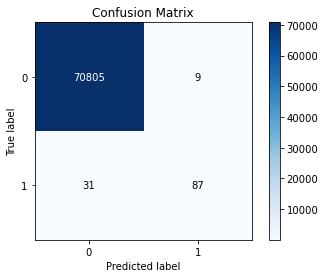



Classification report:-

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.91      0.74      0.81       118

    accuracy                           1.00     70932
   macro avg       0.95      0.87      0.91     70932
weighted avg       1.00      1.00      1.00     70932

**************************************************************************


In [41]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced')
cv=RepeatedStratifiedKFold()
cal_dt = CalibratedClassifierCV(base_estimator=dt,cv=cv,method='isotonic',n_jobs=-1)

print('Results for Decision Tree classifier:-\n')

start_time = time.time()
cal_dt.fit(X_train,y_train)
dt_time = (time.time() - start_time)
print('Training time(sec) = ',dt_time)

y_pred1 = cal_dt.predict(X_train)

start_time = time.time()
y_pred = cal_dt.predict(X_test)
dt_time2 = (time.time() - start_time)
print('Prediction time(sec) = ',dt_time2)

y_pred_prob1 = cal_dt.predict_proba(X_train)
y_pred_prob = cal_dt.predict_proba(X_test)

cm_dt = confusion_matrix(y_test, y_pred)
dt_miss = np.sum(y_pred!=y_test.values.ravel())
acc1_dt = balanced_accuracy_score(y_train,y_pred1)
acc2_dt = balanced_accuracy_score(y_test,y_pred)
loss1_dt = log_loss(y_train,y_pred_prob1)
loss2_dt = log_loss(y_test,y_pred_prob)

print('\n\nTraining score = ',acc1_dt)
print('Tesing score = ',acc2_dt)
print('\n')

for i in range(len(y_train['Class'].unique())):
    err = np.sum(cm_dt[i])-cm_dt[i][i]
    print('No of missclassified for class {} (test data) = {} '.format(label[i],err))
print('Total no of missclassified points(test data) = ',dt_miss)
print('Total % of missclassified points(test data) = ',dt_miss/len(y_test))

print('\n\nTraining log_loss = ',loss1_dt)
print('Tesing log_loss = ',loss2_dt)
print('\n\nConfusion matrix:')
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
print('\n\nClassification report:-\n')
print(classification_report(y_test,y_pred))
print('**************************************************************************')
DT = [acc1_dt,acc2_dt,dt_miss,dt_miss/len(y_test),loss1_dt,loss2_dt,dt_time,dt_time2]

In [44]:
s1=[MNB,LR,LDA,QDA,MNB,SVC,DT]
s2=['GNB','LR','LDA','QDA','GNB','SVC','DT']
col=['Train score','Test score','Missclassified-point','% missclasification','Train log-loss','Test log-loss','Training time','Prediction time']
result2=dict.fromkeys(s2,None)

for i in range(len(s1)):
    result2[s2[i]] = s1[i]

In [45]:
temp = pd.DataFrame.from_dict(result2, orient='index',columns=col).reset_index()
result2 = temp.rename(columns={'index':'Classifiers'})

In [46]:
result2

,Classifiers,Train score,Test score,Missclassified-point,% missclasification,Train log-loss,Test log-loss,Training time,Prediction time
0,GNB,0.920187,0.901591,1356,0.019117,0.415302,0.403915,0.114685,0.033118
1,LR,0.873105,0.847366,49,0.000691,0.002960,0.003926,10.799076,0.407387
2,LDA,0.894244,0.864315,45,0.000634,0.002915,0.003688,12.517993,0.405141
3,QDA,0.844896,0.826102,65,0.000916,0.003604,0.004407,10.979390,3.282240
4,SVC,0.884415,0.843143,48,0.000677,0.002788,0.003719,665.749094,0.392103
5,DT,1.000000,0.868581,40,0.000564,0.001046,0.003877,78.435096,0.729923


In [28]:
result

,Classifiers,Train score,Test score,Missclassified-point,% missclasification,Train log-loss,Test log-loss,Training time,Prediction time
0,GNB,0.919558,0.898188,1838,0.025912,0.609470,0.606418,0.200063,0.046890
1,LR,0.880152,0.851596,49,0.000691,0.002913,0.004252,26.156462,0.430555
2,LDA,0.898467,0.864308,46,0.000649,0.002783,0.003578,20.926468,0.533790
3,QDA,0.760408,0.732888,86,0.001212,0.003962,0.004717,18.511280,5.013073
4,SVC,0.885817,0.847366,49,0.000691,0.002795,0.003753,832.046378,0.457669
5,DT,1.000000,0.851660,40,0.000564,0.001076,0.003992,110.030845,0.831316
